In [1]:
import numpy as np
import pandas as pd
from typing import Dict, List, Any
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn import metrics
from imblearn.over_sampling import SMOTE

# classification algorithms 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# metrics
from sklearn.metrics import make_scorer, roc_auc_score, confusion_matrix,precision_score, recall_score, accuracy_score, balanced_accuracy_score, classification_report, precision_recall_curve, roc_curve,f1_score    

import joblib

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# TODO:
# import black
# import jupyter_black
# jupyter_black.load(
#     lab=True,
#     line_length=100,
#     verbosity="INFO",
#     target_version=black.TargetVersion.PY310,
# )

In [2]:
# read the data   # TODO: function
path_to_train_data = "../data/train_file.xlsx"
df = pd.read_excel(path_to_train_data)
df.head() 

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,0,nonexistent,no


In [3]:
df.drop_duplicates(keep="last", inplace=True)  # remove duplicate

#### Remove some features or their categories

The following *features* will be removed:
* **duration**: This feature is highly correlated with the dependent variable "y". The data suggest that longer contact times are associated with a higher probability of subscribing to a fixed-term deposit. However, the duration of a contact is only known after the contact has been completed and the customer has made his decision. If we want to use this model for predictive inference in production, where predictions need to be made before the contact takes place, including "duration" as a feature is impractical. Therefore, this feature should be excluded from the training data to ensure that the model can be used effectively for real-time prediction.
* **day_of_week**: EDA has shown that this feature does not have a significant impact on the customer"s decision. Given its minimal impact, including it as a feature would not significantly improve the predictive performance of the model. Removing this feature from the training data helps to simplify the model and focus on more important features.

In [4]:
features_to_remove = ["duration", "day_of_week"]
df_adjusted = df.drop(features_to_remove, axis=1)

**Dealing with unknown categories:** the *"unknown"* categories for such features, such as "job", "education", "default", "housing", "loan" will be removed, as they don"t provide significant predictive value.

In [5]:
df_adjusted = df_adjusted.query('job != "unknown" & education != "unknown" & default != "unknown" & housing != "unknown"')
df_adjusted.reset_index(inplace=True)

**Combining basic education categories:** to simplify the dataset and improve model performance, all basic education categories ("basic.4y", "basic.6y", "basic.9y") are combined into a single, more general category "education.basic". This will reduce the complexity of the education feature and help the model to generalize better by treating all levels of basic education as equivalent.

In [6]:
df_adjusted["education"] = df_adjusted["education"].replace(["basic.4y", "basic.6y", "basic.9y"], "education.basic")
df_adjusted.sample(n=3)

,index,age,job,marital,education,default,housing,loan,contact,month,campaign,previous,poutcome,y
3013,4111,29,admin.,single,high.school,no,yes,no,cellular,jun,2,0,nonexistent,no
11460,15598,32,blue-collar,single,high.school,no,yes,no,telephone,may,2,0,nonexistent,no
16365,22235,30,blue-collar,married,education.basic,no,no,no,telephone,nov,1,0,nonexistent,yes


**Binning age:** given the wide distribution of ages in the dataset, we will split this category into four quantile-based bins. This approach will group the ages into four equally sized bins, which will help to normalize the distribution and potentially improve the performance of the model by reducing the effect of outliers.

In [7]:
bins_nmb = 5
age_order = ["young", "young_adult", "middle_aged", "late_middle_aged", "middle_old_age"]
bins_age = pd.cut(df_adjusted["age"], bins=bins_nmb, labels=age_order)
df_adjusted.insert(1, "bins_age", bins_age) # Min/Max in each bin: [(16.926, 31.8] < (31.8, 46.6] < (46.6, 61.4] < (61.4, 76.2] < (76.2, 91.0]]
# remove age column from dataframe
df_adjusted.drop("age", axis=1, inplace=True)

In [8]:
# bins_age

#### Pipeline definition with encoding and scaling categorical and numerical features

In [9]:
# encoding with LabelEncoder
label_encoder = LabelEncoder()
df_adjusted["contact"] = label_encoder.fit_transform(df_adjusted["contact"])

# encoding with binary values
binary_mapping = {"yes": 1, "no": 0}
columns_to_map = ["default", "loan", "housing", "y"]
for column in columns_to_map:
    df_adjusted[column] = df_adjusted[column].map(binary_mapping)

In [10]:
df_adjusted.head()

,index,bins_age,job,marital,education,default,housing,loan,contact,month,campaign,previous,poutcome,y
0,1,young_adult,entrepreneur,married,university.degree,0,0,0,1,nov,2,1,failure,0
1,2,middle_old_age,retired,married,education.basic,0,0,0,0,jul,1,0,nonexistent,1
2,3,young_adult,admin.,married,university.degree,0,1,0,1,may,2,0,nonexistent,0
3,4,middle_aged,retired,divorced,university.degree,0,0,0,0,jun,2,0,nonexistent,0
4,5,young,admin.,single,university.degree,0,0,0,0,aug,2,0,nonexistent,0


In [11]:
# hierarchical order for some ordinal features
education_order = ["illiterate", "education.basic", "high.school", "professional.course", "university.degree"]
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
poutcome_order = ["nonexistent", "failure", "success"]

In [12]:
# define ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # ordinal encoding
        ("bins_age_enc", Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[age_order])),
            ('scaler', StandardScaler())
        ]), ['bins_age']),
        ("education", Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[education_order])),
            ('scaler', StandardScaler())
        ]), ['education']),
        ("month", Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[month_order])),
            ('scaler', StandardScaler())
        ]), ['month']),
        ("poutcome", Pipeline(steps=[
            ('ordinal', OrdinalEncoder(categories=[poutcome_order])),
            ('scaler', StandardScaler())
        ]), ['poutcome']),
        
        # LabelEncoder was applied separately
        ("contact", "passthrough", ["contact"]),
        
        # binary encoding was applied separately
        ("binary", "passthrough", ["default", "loan", "housing"]),
        
        # One-Hot encoding for job and marital
        ("job_marital", OneHotEncoder(), ["job", "marital"]),
        
        # Standard scaling of the rest numeric features
        ("scaling", StandardScaler(), ["previous", "campaign"])
    ],
    remainder="passthrough"  # leave the other columns unchanged
)

In [13]:
# Split the data into training and test sets
X = df_adjusted.drop("y", axis=1)
y = df_adjusted["y"]

#### Data splitting and balancing

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
print(f"Training set shape: {X_train.shape} --- {y_train.shape}")
print(f"Testing set shape: {X_test.shape} --- {y_test.shape}")

Training set shape: (21882, 13) --- (21882,)
Testing set shape: (2432, 13) --- (2432,)


#### Model selection

In [15]:
# define the models
models = {
    "LogisticRegression": LogisticRegression(solver="liblinear", max_iter=1000),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    # "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

##### Model evaluation using cross-validation

In [16]:
def show_conf_mtx(y_gold, y_pred, model_name):
    conf_mtx = confusion_matrix(y_gold, y_pred)
    plt.figure(figsize=(4, 2))
    sns.heatmap(conf_mtx, annot=True, cmap="Blues", fmt='d', cbar=False, annot_kws={"fontsize":8})
    plt.title(f'{model_name}', fontsize=10, pad=10)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('True', fontsize=8)
    plt.show()

In [17]:
# models evaluation using cross-validation
def get_mean_val(scores_dict: Dict[str, np.ndarray], val_name: str):
    if val_name not in scores_dict:
        raise KeyError(f"{val_name} is not found in the scores dictionary.")
    return scores_dict[val_name].mean()
    
results = {}
skf = StratifiedKFold(n_splits=5) # StratifiedKFold is used by default for classification tasks

metrics = [
    'accuracy',
    'f1',
    "roc_auc"]

for model_name, model in models.items():    
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE()),  # since the data is very imbalanced, it's better to balance them
        ('classifier', model)
    ])

    cv_scores_dict = {}
    cv_scores = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=metrics)
    results[model_name] = {"fit_time_mean": get_mean_val(cv_scores, "fit_time"),
                           "accuracy_mean": get_mean_val(cv_scores, "test_accuracy"),
                           "f1_mean": get_mean_val(cv_scores, "test_f1"),
                           "roc_auc_mean": get_mean_val(cv_scores, "test_roc_auc")
                          }

In [ ]:
results

# best model based on F1 score
best_model_name = max(results, key=lambda model: results[model]["accuracy_mean"])
best_model_name 

##### Train the best model on the full training data

In [20]:
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('classifier', models[best_model_name])
])
pipeline.fit(X_train, y_train)

# model evaluation on the test date
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.94      2126
           1       0.60      0.17      0.26       306

    accuracy                           0.88      2432
   macro avg       0.74      0.58      0.60      2432
weighted avg       0.85      0.88      0.85      2432



In [21]:
##### TODO: remove
best_model_name = "GradientBoosting"

##### Hyperparameter tuning of the best model

In [22]:
# # predifine a set of hyperparameters for the models
# # Common parameters
# max_depth_values = [None, 2]  # how deep the built tree can be
# min_samples_split_values = [1, 2, 0.01]  # minimum number of samples required to split an internal node
# min_samples_leaf_values = [0.5, 1]  # minimum number of samples required to be at a leaf node
# n_estimators_values = [90, 100]  # the number of trees in the forest
# max_features_values = ["sqrt"]  # number of features to consider when looking for the best split

# models_params = {
#     "LogisticRegression":  {
#         'classifier__C': [0.001, 0.01, 0.1, 1],   # Regularization parameter, controlling the trade-off between maximizing the margin and minimizing classification error
#         'classifier__solver': ["liblinear", "newton-cholesky"]
#     },
#     "DecisionTreeClassifier": {
#         'classifier__splitter': ["best", "random"],
#         'classifier__max_depth': max_depth_values,
#         'classifier__class_weight': [None, "balanced"]
#     },
#     "RandomForest": {
#         'classifier__n_estimators': n_estimators_values,
#         'classifier__max_features': max_features_values,
#         'classifier__max_depth': max_depth_values,
#         'classifier__min_samples_split': min_samples_split_values,
#         'classifier__min_samples_leaf': min_samples_leaf_values
#     },
#     "GradientBoosting": {
#         'classifier__n_estimators': n_estimators_values,
#         'classifier__learning_rate': [0.1, 0.01, 0.001],  # reduce the contribution of each tree by lr
#         'classifier__max_depth': max_depth_values,
#         # 'classifier__min_samples_split': min_samples_split_values,
#         'classifier__min_samples_leaf': min_samples_leaf_values,
#         # 'classifier__max_features': max_features_values
#     },
#     "SVM": {
#         'classifier__C': [0.1, 1, 10, 100],
#         'classifier__gamma': [1, 0.1, 0.01, "scale", "auto"],
#         'classifier__kernel': ["linear", "poly", "rbf"]
#     },
#     "KNN": {
#         'classifier__n_neighbors': np.arange(2, 20, 1),
#         'classifier__weights': ['uniform', 'distance'],
#         'classifier__metric': ['l2', 'manhattan', 'cosine']
#     }
# }

In [40]:
# hyperparemeter tuning with optuna
import optuna

def objective(trial):
     # Define hyperparameters to tune
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.2)
    n_estimators = trial.suggest_int('n_estimators', 1, 40)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 50)

    # Create the model with trial parameters
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Define the pipeline with SMOTE and the preprocessor
    pipeline = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE()),
        ('classifier', model)
    ])
    
   
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, scoring='f1', cv=skf, n_jobs=-1)
    mean_cv_score = cv_scores.mean()
    
    # Report intermediate values for pruning
    trial.report(mean_cv_score, step=0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    
    # Return the mean of the cross-validation scores
    return mean_cv_score

# Set up the Optuna study
n_trials=200
study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters
print(f'Best hyperparameters: {study.best_params}')

# Train the final model with the best hyperparameters
best_params = study.best_params
best_model = GradientBoostingClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)

# Define the pipeline with the best model
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE()),
    ('classifier', best_model)
])

# Train the model on the full training set
pipeline.fit(X_train, y_train)

# Evaluate the model on the test set
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

[I 2024-06-02 23:46:00,917] A new study created in RDB with name: no-name-a425881f-c430-460c-b5d3-51225360c1f1
[I 2024-06-02 23:46:03,476] Trial 0 finished with value: 0.36208517032798276 and parameters: {'learning_rate': 0.15135935199284162, 'n_estimators': 6, 'max_depth': 9, 'min_samples_split': 17, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.36208517032798276.
[I 2024-06-02 23:46:06,249] Trial 1 finished with value: 0.3400452572275995 and parameters: {'learning_rate': 0.18692596568051642, 'n_estimators': 13, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 20}. Best is trial 0 with value: 0.36208517032798276.
[I 2024-06-02 23:46:07,651] Trial 2 finished with value: 0.308515517273234 and parameters: {'learning_rate': 0.1626299560159817, 'n_estimators': 5, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 31}. Best is trial 0 with value: 0.36208517032798276.
[I 2024-06-02 23:46:09,111] Trial 3 finished with value: 0.3871451567646773 and parameters: {'l

Best hyperparameters: {'learning_rate': 0.060889682566560854, 'n_estimators': 5, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 26}
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      2126
           1       0.52      0.27      0.36       306

    accuracy                           0.88      2432
   macro avg       0.71      0.62      0.65      2432
weighted avg       0.85      0.88      0.86      2432



In [41]:
# # get the parameters for tuning based on best model
# params_to_tune = models_params[best_model_name]  # Change this to the parameter grid for the chosen model
# print(f"Following parameters of the '{best_model_name}' model will be tuned:\n{params_to_tune}")

# # hyperparameter tuning with GridSearchCV
# pipeline = ImbPipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('smote', SMOTE()),
#     ('classifier', models[best_model_name])
# ])

# grid_search = GridSearchCV(pipeline, params_to_tune, cv=skf, scoring='f1', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(f'Best parameters of {best_model_name} model: {grid_search.best_params_}')
# print(f'Best CV F1 Score: {grid_search.best_score_}')

# # Train the best model on the full training set with the best parameters
# best_model = grid_search.best_estimator_
# best_model.fit(X_train, y_train)

# # Evaluate the best model on the test set
# y_pred = best_model.predict(X_test)


# # Output the test predictions and evaluation
# print(classification_report(y_test, y_pred))

In [42]:
def compute_metrics_scores(y_target, y_predicted) -> Dict[str, Any]:
    metric_types = [accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score]
    metric_scores_dict = dict()
    for metric_class in metric_types:
        metric_name = metric_class.__name__
        metric = metric_class(y_target, y_predicted)  # initialize metric
        metric_scores_dict[f"{metric_name}"] = metric
    return metric_scores_dict

metric_scores = compute_metrics_scores(y_test, y_pred)
metric_scores

{'accuracy_score': 0.8770559210526315,
 'balanced_accuracy_score': 0.6191457768431926,
 'f1_score': 0.35974304068522484,
 'roc_auc_score': 0.6191457768431926}

In [43]:
# Generate ROC curve and Precision-Recall curve
false_positive_rate, true_positive_rate, _ = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

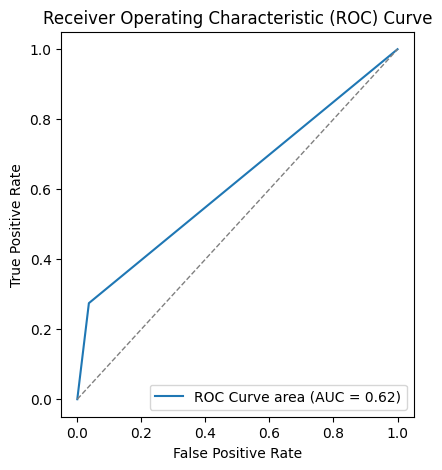

In [44]:
# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(false_positive_rate, true_positive_rate, label=f'ROC Curve area (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

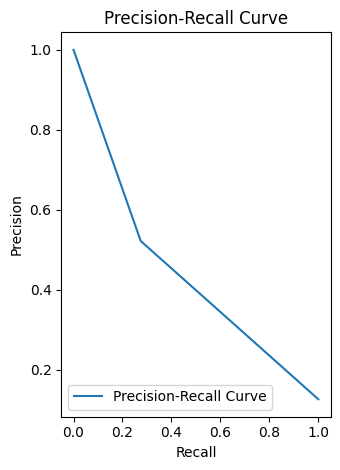

In [45]:
# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


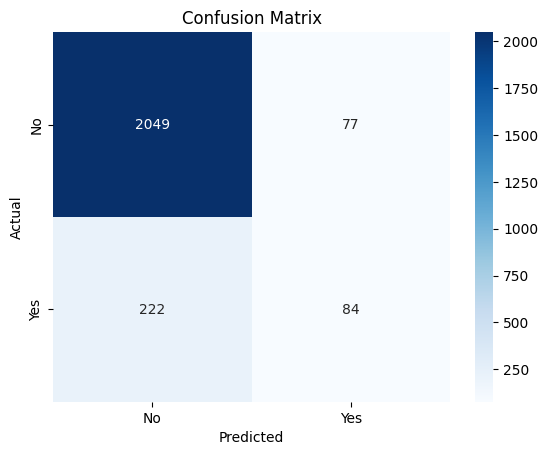

In [46]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

#### Persist the model and preprocessor and make predictions

In [47]:
# Persist the trained model and preprocessor
joblib.dump(pipeline, 'trained_model_pipeline.pkl')

# Load the model and preprocessor for future use
loaded_pipeline = joblib.load('trained_model_pipeline.pkl')

In [48]:
# read the data   # TODO: function
path_to_test_data = "../data/test_file.xlsx"
df_test_data = pd.read_excel(path_to_test_data)
df_test_data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome
0,34,services,married,high.school,no,no,no,telephone,may,thu,214,4,0,nonexistent
1,29,blue-collar,single,basic.9y,no,no,no,cellular,jul,thu,190,1,0,nonexistent
2,35,admin.,single,high.school,no,no,no,cellular,may,wed,152,2,0,nonexistent
3,60,admin.,divorced,high.school,no,yes,no,cellular,jul,fri,179,1,0,nonexistent
4,45,management,married,university.degree,no,no,no,telephone,may,wed,105,2,0,nonexistent
5,31,blue-collar,married,basic.9y,no,yes,no,telephone,may,thu,141,1,0,nonexistent
6,39,blue-collar,married,professional.course,no,no,no,telephone,may,mon,87,5,0,nonexistent
7,67,retired,married,professional.course,no,yes,yes,cellular,aug,mon,186,1,0,nonexistent
8,21,student,single,high.school,no,no,no,cellular,jun,thu,400,1,0,nonexistent
9,53,retired,married,high.school,unknown,no,no,telephone,may,wed,264,2,0,nonexistent


In [49]:
df_test_data = df_test_data.drop(features_to_remove, axis=1)
df_test_data.query('job != "unknown" & education != "unknown" & default != "unknown" & housing != "unknown"', inplace=True)
df_test_data.reset_index(inplace=True)
df_test_data["education"] = df_test_data["education"].replace(["basic.4y", "basic.6y", "basic.9y"], "education.basic")

In [50]:
bins_age = pd.cut(df_test_data["age"], bins=bins_nmb, labels=age_order)
df_test_data.insert(1, "bins_age", bins_age)
# remove age column from dataframe
df_test_data.drop("age", axis=1, inplace=True)
df_test_data

,index,bins_age,job,marital,education,default,housing,loan,contact,month,campaign,previous,poutcome
0,0,young_adult,services,married,high.school,no,no,no,telephone,may,4,0,nonexistent
1,1,young,blue-collar,single,education.basic,no,no,no,cellular,jul,1,0,nonexistent
2,2,young_adult,admin.,single,high.school,no,no,no,cellular,may,2,0,nonexistent
3,3,middle_old_age,admin.,divorced,high.school,no,yes,no,cellular,jul,1,0,nonexistent
4,4,middle_aged,management,married,university.degree,no,no,no,telephone,may,2,0,nonexistent
5,5,young_adult,blue-collar,married,education.basic,no,yes,no,telephone,may,1,0,nonexistent
6,6,young_adult,blue-collar,married,professional.course,no,no,no,telephone,may,5,0,nonexistent
7,7,middle_old_age,retired,married,professional.course,no,yes,yes,cellular,aug,1,0,nonexistent
8,8,young,student,single,high.school,no,no,no,cellular,jun,1,0,nonexistent
9,11,middle_aged,admin.,married,professional.course,no,yes,no,telephone,may,1,0,nonexistent


In [51]:
# encoding with LabelEncoder
label_encoder = LabelEncoder()
df_test_data["contact"] = label_encoder.fit_transform(df_test_data["contact"])

# encoding with binary values
binary_mapping = {"yes": 1, "no": 0}
columns_to_map = ["default", "loan", "housing"]  # no y
for column in columns_to_map:
    df_test_data[column] = df_test_data[column].map(binary_mapping)

In [52]:
df_test_data

,index,bins_age,job,marital,education,default,housing,loan,contact,month,campaign,previous,poutcome
0,0,young_adult,services,married,high.school,0,0,0,1,may,4,0,nonexistent
1,1,young,blue-collar,single,education.basic,0,0,0,0,jul,1,0,nonexistent
2,2,young_adult,admin.,single,high.school,0,0,0,0,may,2,0,nonexistent
3,3,middle_old_age,admin.,divorced,high.school,0,1,0,0,jul,1,0,nonexistent
4,4,middle_aged,management,married,university.degree,0,0,0,1,may,2,0,nonexistent
5,5,young_adult,blue-collar,married,education.basic,0,1,0,1,may,1,0,nonexistent
6,6,young_adult,blue-collar,married,professional.course,0,0,0,1,may,5,0,nonexistent
7,7,middle_old_age,retired,married,professional.course,0,1,1,0,aug,1,0,nonexistent
8,8,young,student,single,high.school,0,0,0,0,jun,1,0,nonexistent
9,11,middle_aged,admin.,married,professional.course,0,1,0,1,may,1,0,nonexistent


In [55]:
# Load the model and preprocessor for future use
loaded_pipeline = joblib.load('trained_model_pipeline.pkl')

# Use the loaded model to make predictions on new data
new_predictions = loaded_pipeline.predict(df_test_data)
print(new_predictions)

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [56]:
for i, pred in enumerate(new_predictions):
    if pred == 1:
        print(f"{i}: {pred}")

7: 1
